In [454]:
import matplotlib.pyplot as plt
import requests
from thesportsdb.TheSportsDbRepository import *
from thesportsdb.Cleaner import *
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from thesportsdb.Modelization import *
from thesportsdb.Cleaner import *
from thesportsdb.Predictor import *
from thesportsdb.TheSportsDbRepository import *
import pandas as pd
from thesportsdb.StaticInfos import StaticInfos


<h1>Formation du dataframe à partir de l'api thesportsdb </h1>

<p>Récupération et concaténation grâce à des requêtes vers cette API (voir package thesportdb)

In [455]:
nextRoundId = getNextRoundId() - 1
matchsForRound = (getEventRoundForLigue(StaticInfos.ligue1Id, nextRoundId))
df = pd.DataFrame(matchsForRound)
df = cleanEvents(df)
dfTotal = pd.DataFrame()
load5LastMatchs(nextRoundId)
for i in range(0, len(df)):
    match = df.iloc[i]
    awayDataframe = getDataframe(int(match['idAwayTeam']))
    homeDataframe = getDataframe(int(match['idHomeTeam']))
    if dfTotal.empty:
        dfTotal = pd.concat([awayDataframe, homeDataframe])
    else:
        dfMatch = pd.concat([awayDataframe, homeDataframe])
        dfTotal = pd.concat([dfTotal, dfMatch])

5 Premières lignes et les clés du tableau

In [456]:
print(dfTotal.keys())
dfTotal.head()

Index(['score5LastMatchs', 'goalAverageLast5Matchs', 'last5MatchsScoredGoals',
       'last5MatchsConcededGoals', 'last5MatchsWins', 'last5MatchsLoss',
       'opponentScore5LastMatchs', 'opponentGoalAverageLast5Matchs',
       'opponentLast5MatchsScoredGoals', 'opponentLast5MatchsConcededGoals',
       'opponentLast5MatchsWins', 'opponentLast5MatchsLoss', 'isHome',
       'isWinning', 'scoredGoals', 'concededGoals', 'nameTeam',
       'opponentNameTeam'],
      dtype='object')


,score5LastMatchs,goalAverageLast5Matchs,last5MatchsScoredGoals,last5MatchsConcededGoals,last5MatchsWins,last5MatchsLoss,opponentScore5LastMatchs,opponentGoalAverageLast5Matchs,opponentLast5MatchsScoredGoals,opponentLast5MatchsConcededGoals,opponentLast5MatchsWins,opponentLast5MatchsLoss,isHome,isWinning,scoredGoals,concededGoals,nameTeam,opponentNameTeam
0,86.666667,5,9,4,4,0,86.666667,7,8,1,4,0,0,0,0,4,Lens,Lille
1,66.666667,2,8,6,3,1,66.666667,3,8,5,3,1,1,1,2,0,Lens,St Etienne
2,60.000000,2,7,5,3,1,26.666667,1,7,6,1,2,0,0,1,1,Lens,Nimes
3,40.000000,1,5,4,2,1,33.333333,2,2,0,1,0,1,1,2,1,Lens,Bordeaux
4,20.000000,0,2,2,1,1,20.000000,0,3,3,1,1,0,1,3,2,Lens,Lorient


Quel est le pourcentage minimum et maximum du nombre de points glanés sur une série de 5 matchs conséccutifs ?

In [457]:
print("Minimum : %d" % (dfTotal["score5LastMatchs"].min()))
print("Maximum : %d" % (dfTotal["score5LastMatchs"].max()))

Minimum : 0
Maximum : 86


Quelles sont les équipes qui ont le plus petit nombre de points glanés sur une série de 5 matchs ?

In [458]:
(dfTotal[dfTotal["score5LastMatchs"] == dfTotal["score5LastMatchs"].min()]["nameTeam"]).head().unique()

array(['Brest', 'Dijon', 'Strasbourg'], dtype=object)

À l'inverse lesquelles ont connu une grande période d'efficacité ?

In [459]:
(dfTotal[dfTotal["score5LastMatchs"] == dfTotal["score5LastMatchs"].max()]["nameTeam"]).head().unique()

array(['Lens', 'Rennes', 'Lille'], dtype=object)

Chance qu'une équipe l'emporte par rapport à sa série de défaite
On observe que les équipes qui ne perdent pas s'en sortent le mieux
Toutefois, Certaines équipes arrivent à se sortir d'une mauvaise série, notammenent celles qui ont eu 3 défaites sur les derniers matchs

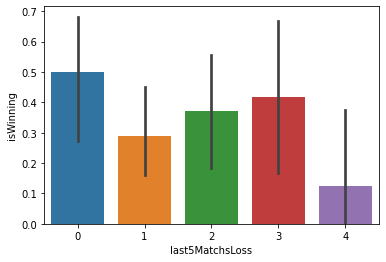

In [460]:
from sklearn.cluster import KMeans

sns.barplot(x='last5MatchsLoss', y= 'isWinning', data=dfTotal)
plt.show()

<h3>Essayons de trouver des corrélations entre les colonnes grâce à ce heatmap</h3>
<p>On peut voir que le goalAverage des 5 derniers matchs d'une équipe influe sur le nombre de victoires mais beaucoup moins que le nombre de défaites. <br>
 AInsi, les équipes qui ont un goalAverage loin de 0 (positifs en l'occurence), semblent être celles qui ont tendance à gagner.</p>
<p>De même, le nombre de buts marqués semble avoir plus d'impact que le nombre de buts encaissés. Une fois encore ce sont les équipes qui ont tendance à gagner qui se distinguent dans ce dataframe.</p>
<p>Peu de colonnes semblent vraiment influer sur la victoire (IsWinning) si ce n'est legérement, le goalAverage ou le fait d'être à la maison</p>

<AxesSubplot:>

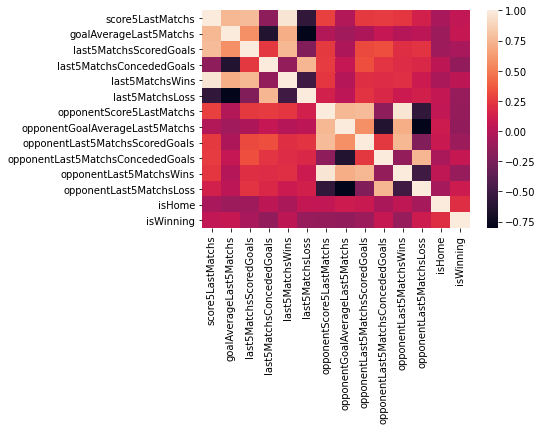

In [461]:
# calculate the correlation matrix
corr = dfTotal.corr()

# plot the heatmap
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<h2>Entrainement du modèle avec le RandomForestClassifier

In [462]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import  train_test_split
X = dfTotal[['isWinning', 'isHome', 'last5MatchsWins', 'last5MatchsLoss','opponentGoalAverageLast5Matchs' ,'last5MatchsConcededGoals', 'opponentLast5MatchsLoss', 'opponentLast5MatchsWins','opponentLast5MatchsConcededGoals','opponentLast5MatchsScoredGoals',
                 'last5MatchsScoredGoals', 'score5LastMatchs', 'goalAverageLast5Matchs', 'opponentScore5LastMatchs']]
y = dfTotal['isWinning']
del X['isWinning']
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
from sklearn.metrics import accuracy_score
cls = RandomForestClassifier(n_estimators=200, max_depth=2).fit(x_train, y_train)
score = cls.score(x_val, y_val)
filename = StaticInfos.pickleFileName
pickle.dump(cls, open(filename, 'wb'))
print(score)

0.55


<p>Résultat assez moyen, il manque des lignes au dataset initial (seulement  100), mais les données de cette api sont limitées
<p>Une source de données avec un nombre de renseignements plus important aurait été préférable ainsi qu'avec des données plus singulières telles que la note des joueurs de chaque équipe

<h5>Test de prédiction à partir de deux identifiants d'équipe

In [463]:
opposition = getNextMatchDataframe('133822', '133707', type)

In [464]:
cls = pickle.load(open("L1_predict.pkl", "rb"))
x_predictor = opposition[
        ['isHome', 'last5MatchsWins', 'last5MatchsLoss', 'opponentGoalAverageLast5Matchs',
          'last5MatchsConcededGoals', 'opponentLast5MatchsLoss', 'opponentLast5MatchsWins',
          'opponentLast5MatchsConcededGoals', 'opponentLast5MatchsScoredGoals',
          'last5MatchsScoredGoals', 'score5LastMatchs', 'goalAverageLast5Matchs', 'opponentScore5LastMatchs']]
(cls.predict_proba(x_predictor)).max()

0.7654124749768301

L'équipe 133822 est favoris pour ce match

On essaie d'améliorer la performance du modèle grâce à notre matrice de correlation, on ne garde que les colonnes qui influaient un petit peu sur le résultat : isHome et goalAverage.
<br>Le score de réussite est désormais plus régulier , il ne descend plus en dessous de 50% mais monte également moins.
<br>La performance n'est pas forçément meilleure.

In [465]:
from sklearn.model_selection import  train_test_split
X = dfTotal[['isWinning', 'isHome',
                 'opponentGoalAverageLast5Matchs', 'goalAverageLast5Matchs']]
y = dfTotal['isWinning']
del X['isWinning']
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
from sklearn.metrics import accuracy_score
cls = RandomForestClassifier(n_estimators=200, max_depth=2).fit(x_train, y_train)
score = cls.score(x_val, y_val)
score

0.55

 <h2>Matrice de confusion</h1>

In [466]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, cls.predict(x_val))
confusion_matrix

array([[10,  1],
       [ 8,  1]])

<AxesSubplot:>

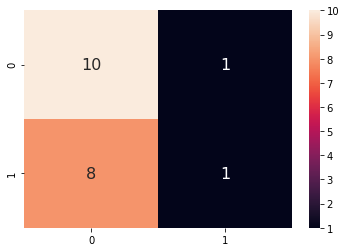

In [467]:
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16}) # font size

On observe que le modèle a un nombre de vrais positifs supérieurs aux faux négatifs, on retrouve aussi des faux négatifs.<br>
 Le nombre de mauvaises prédictions est donc très important, on a la preuve que le modèle a trop peu de données pour qu'il puisse être performant.


 <h3>Conclusion</h3>
 Le choix de la source de données n'était pas le bon et n'a pas permis de faire une prédiction efficace.
 En effet, cette API n'est pas adaptée et est trop limitée pour un système de prediction avec du machine learning. Les résultats sont souvent peu cohérents.
 <br>Utiliser une API payante avec une quanttié de données plus volumineuses et plus détaillées ou bien faire du scrapping sur un site de statistiques footbalistiques aurait probablement donné un meilleur résultat de performance.

